# Named Entity Recognition

NER model trained on 12k sentences with 17 different labels. The training set was very unbalanced which resulted in accuracy at the level of 65%. Considering that the model had more or less 700k parameters generated results are decent. Regardless of architecture, hyperparameters and data manipulation the model still tends to overfit a bit (train acc: 99%, vall acc: 97%).

I couldn't get keras CRF module working so I sticked to simple Bi-GRU model

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle


from keras.optimizers import Adam
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, GRU, Dense
from keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

### EDA

In [2]:
df = pd.read_csv('ner_dataset.txt', sep=',')
df['Word'] = df['Word'].str.lower()
grps = df.groupby('Sentence #')
df.ffill(inplace=True)
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,london,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [14]:
def show_values_on_bars(axs, h_v="v", space=0.4, height=0):
    def _show_on_single_plot(ax):
        
        # vertical axis
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + height
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
                
        # horizontal axis
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")
                
    # multiple plots
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    
    # single plot
    else:
        _show_on_single_plot(axs)

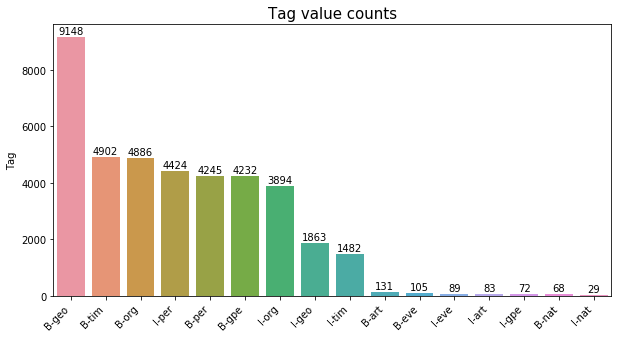

In [15]:
plt.figure(figsize=(10,5))
plot = sns.barplot(x=df['Tag'].value_counts()[1:].index, y=df['Tag'].value_counts()[1:])
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plot.set_title('Tag value counts', size=15)
show_values_on_bars(plot, height=100)
# unbalanced!

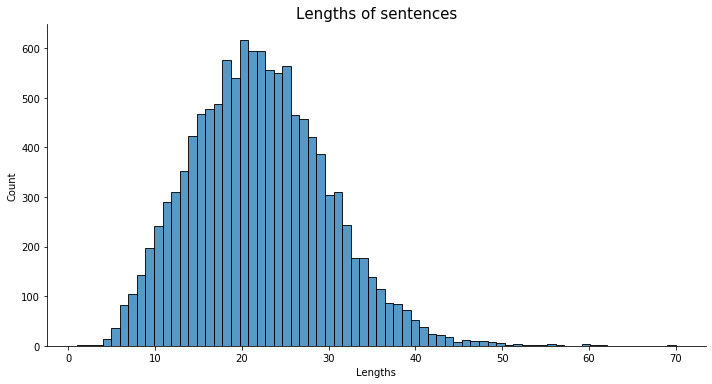

In [16]:
sns.displot(grps.apply(len), height=5, aspect=2, bins=70).set(xlabel='Lengths')
plt.title('Lengths of sentences', size=15);

In [3]:
# calculate max length based on mean and std
max_length = int(np.mean(grps.apply(len)) + 3*np.std(grps.apply(len)))
max_length

45

In [4]:
filtered = grps.filter(lambda x: len(x) <= max_length)
grouped = filtered.groupby('Sentence #')

In [5]:
print('before truncation:\t',     len(grps))
print('after truncation:\t',      len(grouped))
print('% of saved sentences:\t',  np.round(len(grouped)/len(grps), 4))
print('min length:\t\t',          np.min(grouped.apply(len)))
print('max length:\t\t',          np.max(grouped.apply(len)))
print('unique words:\t\t',        len(df['Word'].unique()))
print('unique tokens:\t\t',       len(df['Tag'].unique()))

before truncation:	 11880
after truncation:	 11817
% of saved sentences:	 0.9947
min length:		 1
max length:		 45
unique words:		 16353
unique tokens:		 17


### Preprocessing

In [163]:
df_padded = pd.DataFrame()

for _, grp in tqdm(grouped):
    
    # calculate padding length
    mult = max_length - len(grp)
    
    # insert padding rows to new data frame
    df_app = pd.DataFrame({'Sentence #': [grp['Sentence #'].iloc[0]] * mult,
                           'Word': ['<PAD>'] * mult,
                           'POS': ['<PAD>'] * mult,
                           'Tag': ['<PAD>'] * mult})
    
    grp = grp.append(df_app)
    df_padded = df_padded.append(grp)

In [5]:
# save
# df_padded.to_csv('pandas/df_padded.csv')

# read
df_padded = pd.read_csv('pandas/odf_padded.csv')

In [6]:
# just to be sure everything is fine
for _, grp in df_padded.groupby('Sentence #'):
    assert len(grp) == max_length

In [7]:
# no preprocessing is required since every word is labelled in df
vectorizer = TextVectorization(
    max_tokens=None,
    pad_to_max_tokens=False,
    standardize=None)

# encoder for Tags
encoder = LabelEncoder()

# fit encoders
encoder.fit(df_padded['Tag'].unique())
vectorizer.adapt(df_padded['Word'].to_numpy())

In [8]:
# convert sentenced from df to list of strings
sents = grouped.apply(lambda x: ' '.join(x['Word'].values)).tolist()

In [9]:
# encode to integers
X = vectorizer(sents).numpy()
y = encoder.transform(df_padded['Tag'])

# reshape to desired lengths
assert np.prod(X.shape) == y.shape
y = y.reshape(-1, max_length)

#shuffling
X, y, sents = shuffle(X, y, sents, random_state=2018)
X.shape, y.shape

((11817, 45), (11817, 45))

In [48]:
X[0]

array([    3,    42,    20,   720,     8,  2690,     3,   105,  1824,
        1317,    10,   147,   138,    12,     9, 11903,  5990,     4,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int64)

In [49]:
y[0]

array([ 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16])

In [50]:
sents[0]

'the government was forced to ask the international monetary fund and several countries for a multi-billion-dollar loan .'

In [10]:
# double shuffling cuz why not
xtrain, xtest, ytrain, ytest, _, sents_test = train_test_split(X, y, sents, train_size=0.8, random_state=2018, shuffle=True)
print(xtrain.shape, ytrain.shape)

(9453, 45) (9453, 45)


In [58]:
# since datatset is imbalanced one solution is to assaign every class some weight 
# depending on how many times it appeared in train set
# however I decided no to use them since results were 
# pretty much the same with and without them and 
# documentation wasn't the greatest¯\_(ツ)_/¯
# ... and with class weights train loss exploded and oddly val_loss not

# class_weight = compute_class_weight(class_weight='balanced',
#                                     classes=np.unique(ytrain),
#                                     y=ytrain.flatten())

# class_weight = {k:v for k, v in zip(np.unique(ytrain), class_weight)}

### Model

In [68]:
inputs = Input(shape=(max_length,), dtype='int64', name='input')
x = Embedding(len(df_padded['Word'].unique())+2, 50, name='embedding')(inputs)  # +2? padding and unk?
x = Bidirectional(GRU(50, return_sequences=True, recurrent_dropout=0.2, dropout=0.2), name='bidirectional_gru_1')(x)
outputs = Dense(len(df_padded['Tag'].unique()), activation='softmax', name='output')(x)


model = Model(inputs, outputs, name='NER_Model')
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=.005), metrics=['acc'])

In [69]:
model.summary()

Model: "NER_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 45)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 45, 32)            519136    
_________________________________________________________________
bidirectional_gru_1 (Bidirec (None, 45, 128)           37632     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 45, 128)           74496     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 45, 128)           74496     
_________________________________________________________________
output (Dense)               (None, 45, 17)            2193      
Total params: 707,953
Trainable params: 707,953
Non-trainable params: 0
___________________________________________________

In [71]:
# handy callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss'),
    ModelCheckpoint(filepath='./checkpoints/model-{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True, save_weights_only=True)
]

In [72]:
history = model.fit(xtrain, ytrain,
                    epochs=40,
                    batch_size=256,
                    shuffle=True,
                    validation_split=0.2,
                    callbacks=callbacks)
#                     class_weight=class_weight)

Epoch 1/40
30/30 [==============================] - 34s 793ms/step - loss: 1.7436 - acc: 0.8099 - val_loss: 0.4139 - val_acc: 0.9258
Epoch 2/40
30/30 [==============================] - 22s 747ms/step - loss: 0.3974 - acc: 0.9265 - val_loss: 0.3611 - val_acc: 0.9258
Epoch 3/40
30/30 [==============================] - 21s 699ms/step - loss: 0.3528 - acc: 0.9252 - val_loss: 0.3199 - val_acc: 0.9258
Epoch 4/40
30/30 [==============================] - 22s 733ms/step - loss: 0.3040 - acc: 0.9267 - val_loss: 0.2796 - val_acc: 0.9262
Epoch 5/40
30/30 [==============================] - 21s 692ms/step - loss: 0.2579 - acc: 0.9280 - val_loss: 0.2293 - val_acc: 0.9344
Epoch 6/40
30/30 [==============================] - 21s 706ms/step - loss: 0.2009 - acc: 0.9396 - val_loss: 0.2055 - val_acc: 0.9426
Epoch 7/40
30/30 [==============================] - 21s 684ms/step - loss: 0.1743 - acc: 0.9471 - val_loss: 0.1900 - val_acc: 0.9451
Epoch 8/40
30/30 [==============================] - 21s 718ms/step - 

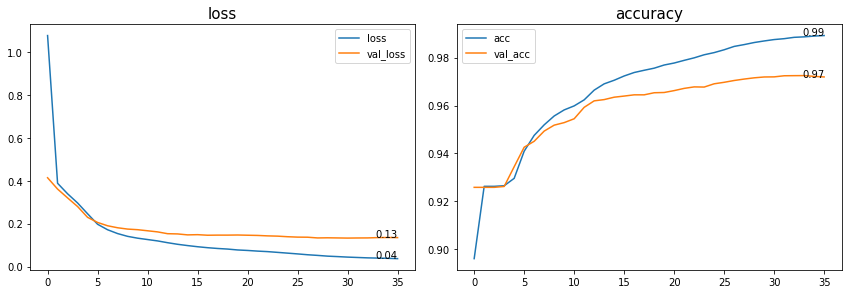

In [73]:
# plot fitting history
def mark_last_element(ax, arr):
    x = len(arr)-1
    y = arr[-1]
    ax.text(x, y, round(arr[-1], 2), ha='right')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()

ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.legend(loc="upper right")
ax1.set_title('loss', size=15)
mark_last_element(ax1, history.history['loss'])
mark_last_element(ax1, history.history['val_loss'])


ax2.plot(history.history['acc'], label='acc')
ax2.plot(history.history['val_acc'], label='val_acc')
ax2.set_title('accuracy', size=15)
ax2.legend(loc="upper left")
mark_last_element(ax2, history.history['acc'])
mark_last_element(ax2, history.history['val_acc'])

plt.show()

In [81]:
model.save_weights('models/proper.h5')

### Results

In [82]:
model.load_weights('models/proper.h5')

In [74]:
# false accuracy!
loss, acc = model.evaluate(xtest, ytest)

74/74 [==============================] - 2s 27ms/step - loss: 0.1380 - acc: 0.9718


In [75]:
# predict values on test dataset
ypred = model.predict(xtest)
ypred = np.argmax(ypred, axis=-1)
ypred = encoder.inverse_transform(ypred.flatten())

ytrue = encoder.inverse_transform(ytest.flatten())

In [124]:
ytrue_filt = []
ypred_filt = []

# skip padding and 'O' tags for better clarity in confusion matrix
for index, (true, pred) in enumerate(zip(ytrue, ypred)):
    if true == pred and true == 'O':
        continue 
    if true == pred and true == '<PAD>':
        continue
    ytrue_filt.append(true)
    ypred_filt.append(pred)

In [125]:
matrix = confusion_matrix(ytrue_filt, ypred_filt)

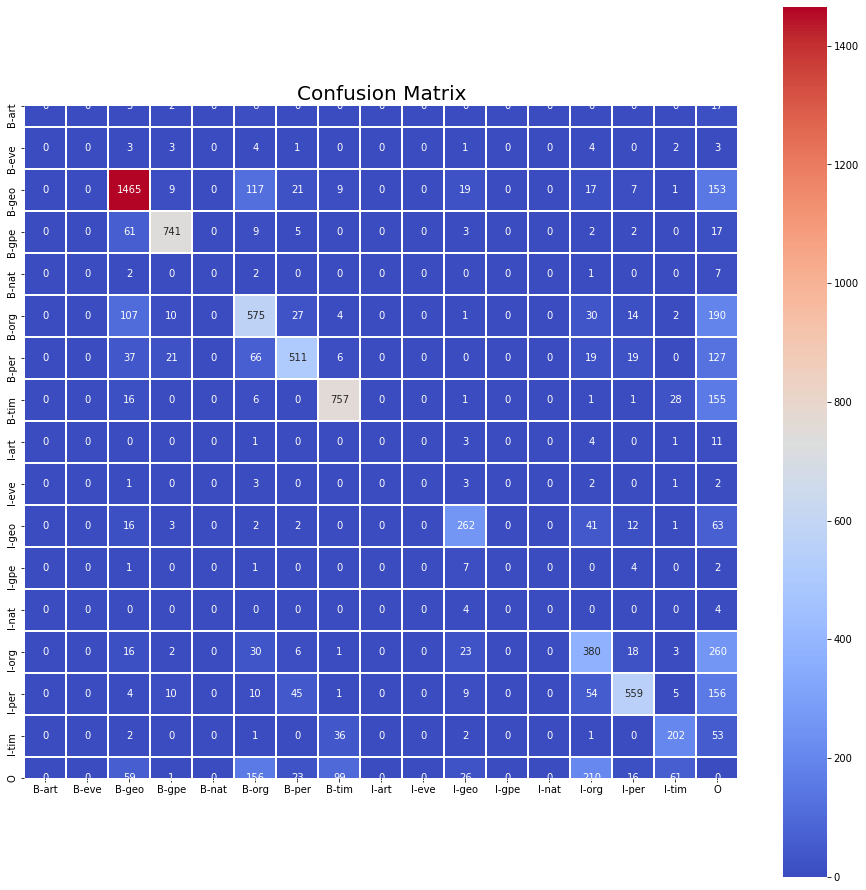

In [126]:
names = encoder.inverse_transform(np.unique(ytest))

plt.figure(figsize=(16,16))
plt.title('Confusion Matrix', size=20)
sns.heatmap(matrix, square=True, xticklabels=names, yticklabels=names, cmap="coolwarm", annot=True, linewidths=1, fmt='g');

In [83]:
# overall accuracy is 65%, could have been better
print(classification_report(ytrue_filt, ypred_filt, labels=names))

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        30
       B-eve       0.00      0.00      0.00        21
       B-geo       0.82      0.81      0.81      1818
       B-gpe       0.92      0.88      0.90       840
       B-nat       0.00      0.00      0.00        12
       B-org       0.58      0.60      0.59       960
       B-per       0.80      0.63      0.71       806
       B-tim       0.83      0.78      0.81       965
       I-art       0.00      0.00      0.00        20
       I-eve       0.00      0.00      0.00        12
       I-geo       0.72      0.65      0.68       402
       I-gpe       0.00      0.00      0.00        15
       I-nat       0.00      0.00      0.00         8
       I-org       0.50      0.51      0.50       739
       I-per       0.86      0.66      0.74       853
       I-tim       0.66      0.68      0.67       297
           O       0.00      0.00      0.00       651

    accuracy              

In [113]:
# function to demonstrate how the model is performs on a given sentence
def examine_sentence(sent, ytrue):
    from tabulate import tabulate
    
    x = vectorizer([sent]).numpy()
    x = pad_sequences(x, padding='post', maxlen=max_length)
    
    preds = model.predict(x)[0]
    preds = np.argmax(preds, axis=-1)
    
    preds = encoder.inverse_transform(preds)
    trues = encoder.inverse_transform(ytrue) # I know ...
    words = sent.split(' ')
    
    data = [[w, p, t] for w, p, t in zip(words, preds, trues)]
    print(tabulate(data, headers=['Word', 'Pred', 'True']))

In [118]:
# 10 random sentences from test set
for i in np.random.randint(0, len(ytest), 10):
    examine_sentence(sents_test[i], ytest[i])
    print('*'*30)

Word         Pred    True
-----------  ------  ------
following    O       O
the          O       O
apology      O       O
,            O       O
bosnian      B-gpe   B-gpe
serb         B-org   I-gpe
president    O       B-per
dragan       B-gpe   I-per
cavic        O       I-per
urged        O       O
indicted     O       O
war          O       O
crimes       O       O
suspects     O       O
to           O       O
surrender    O       O
to           O       O
authorities  O       O
,            O       O
saying       O       O
it           O       O
is           O       O
crucial      O       O
for          O       O
the          O       O
future       O       O
of           O       O
the          O       O
bosnia       B-geo   B-geo
serb         I-per   B-gpe
republic     I-geo   B-geo
.            O       O
******************************
Word            Pred    True
--------------  ------  ------
mr.             B-per   B-per
hersh           I-per   I-per
asserts         O       O
t